In [437]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import ptvsd

from dct_helper import *
%load_ext autoreload
%autoreload 2

ptvsd.enable_attach()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


('0.0.0.0', 5678)

# Deal Contingent Trades in Trading Book

In [447]:
def dct_sim(n_steps, hedge_r):
    v_z1 = np.random.standard_normal(n_steps)
    v_z2 = hedge_r * v_z1 + np.sqrt(1 - hedge_r**2) * np.random.standard_normal(n_steps)
    v_dc = np.hstack([0, np.cumsum(v_z1)])
    v_hg = - np.hstack([0, np.cumsum(v_z2)])
    return v_dc, v_hg

def dct_sim_det(n_steps, hedge_r):
    nf = 0.6
    r = nf * np.random.standard_normal(n_steps)
    t = np.ones(n_steps) 
    v_z1 = t + r
    v_z2 = t + hedge_r * r + nf * np.sqrt(1-hedge_r**2) * np.random.standard_normal(n_steps)
    
    v_dc = np.hstack([0, np.cumsum(v_z1)])
    v_hg = - np.hstack([0, np.cumsum(v_z2)])
    i_hedge = int(n_steps/5*4)
    v_hg[i_hedge:] = v_hg[i_hedge]
    return v_dc, v_hg
    

In [ ]:
n_steps = 10
t0 = 5
hedge_r = 0.7
v_t = np.arange(n_steps+1)
v_ind = 1 - (v_t > t0)

v_t_pnl = v_t[1:]
v_dc, v_hg = dct_sim_det(n_steps, hedge_r)

v_uhg = v_dc + v_hg

v_dc_niv = v_dc * v_ind
v_uhg_niv = v_dc_niv + v_hg

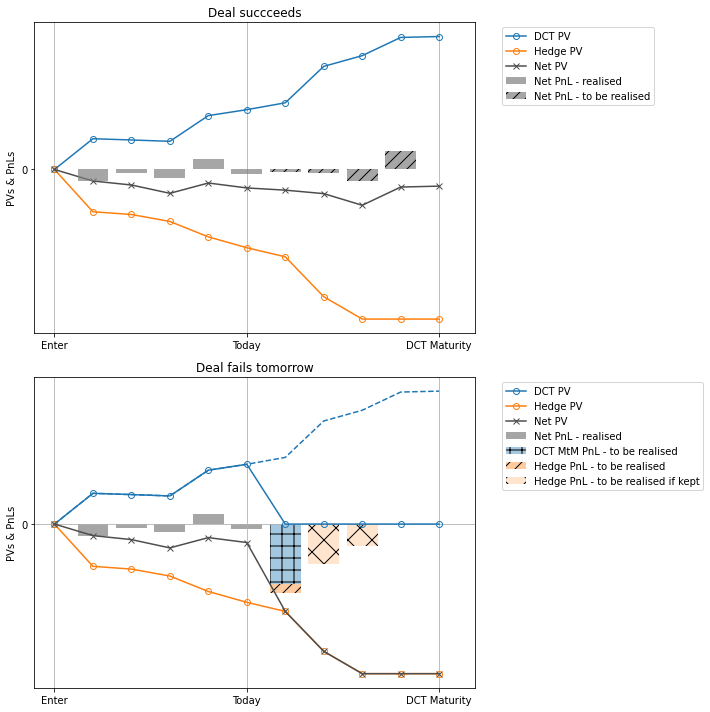

In [517]:

c_white = np.array([1,1,1])
c_pnl = 0.5 * c_white
c_net = 0.3 * c_white

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
p_dc = plt.plot(v_t, v_dc, 'o-', fillstyle='none', label='DCT PV')
p_hd = plt.plot(v_t, v_hg, 'o-', fillstyle='none', label='Hedge PV')
p_uhg = plt.plot(v_t, v_uhg, 'x-', c = c_net, label='Net PV')
plt.bar(v_t_pnl, np.diff(v_uhg) * (v_t[1:] <= t0), color = c_pnl, alpha = 0.7, label='Net PnL - realised', zorder = 10)
plt.bar(v_t_pnl, np.diff(v_uhg) * (v_t[1:] > t0), color = c_pnl, alpha = 0.7, label='Net PnL - to be realised', zorder = 10, hatch = '//')
plt.grid(axis='y')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks([0, t0, n_steps],['Enter', 'Today', 'DCT Maturity'])
plt.yticks([0], ['0'])
plt.ylabel('PVs & PnLs')
plt.title('Deal succceeds')
plt.tight_layout()
plt.grid()

plt.subplot(2,1,2)
p = plt.plot(v_t, v_dc, '--')
plt.plot(v_t, v_dc_niv, 'o-', fillstyle='none', c = p[0].get_color(), label='DCT PV')
p_hg = plt.plot(v_t, v_hg, 'o-', fillstyle='none', label='Hedge PV')
plt.plot(v_t, v_uhg_niv, 'x-', c = c_net, label='Net PV')
plt.bar(v_t_pnl, np.diff(v_uhg_niv) * v_ind[1:], color = c_pnl , alpha = 0.7, label='Net PnL - realised', zorder = -10)
dct_pnl_niv = (-1)* np.diff(v_ind) * np.diff(v_dc_niv)
plt.bar(v_t_pnl, dct_pnl_niv, alpha = 0.4, color = p[0].get_color(), zorder = -5, label = 'DCT MtM PnL - to be realised ', hatch = '+')
b = plt.bar(v_t_pnl, np.diff(v_hg) * (v_t[1:] == t0 + 1), bottom = dct_pnl_niv, color = p_hg[0].get_color() , alpha = 0.4, zorder = -10, label = 'Hedge PnL - to be realised', hatch='//')
b = plt.bar(v_t_pnl, np.diff(v_hg) * (v_t[1:] > t0 + 1), bottom = dct_pnl_niv, color = p_hg[0].get_color() , alpha = 0.2, zorder = -10, label = 'Hedge PnL - to be realised if kept', hatch='x')

plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks([0, t0, n_steps],['Enter', 'Today', 'DCT Maturity'])
plt.yticks([0], ['0'])
plt.ylabel('PVs & PnLs')
plt.title('Deal fails tomorrow')
plt.grid()
plt.tight_layout()
plt.savefig(r'doc/figs/dct-illustration.png')

plt.show()




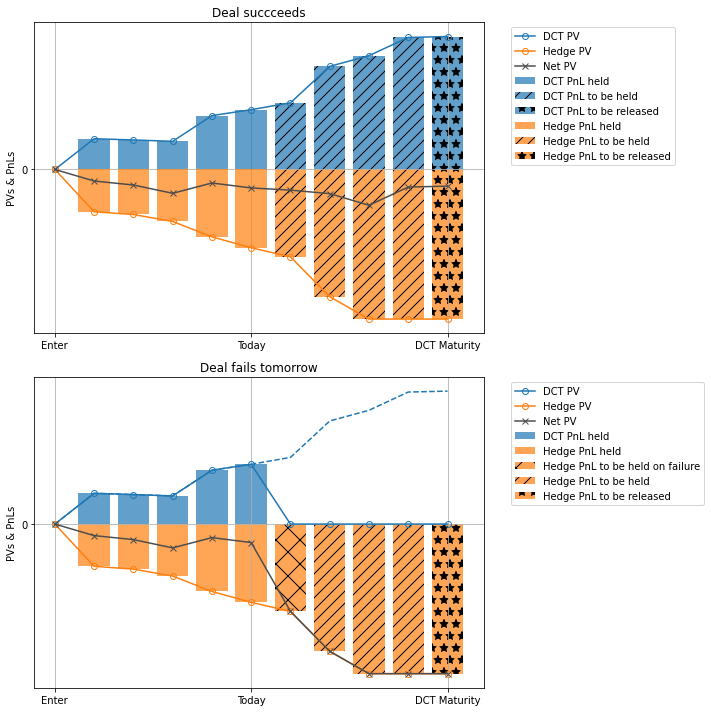

In [518]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
p_dc = plt.plot(v_t, v_dc, 'o-', fillstyle='none', label='DCT PV')
p_hd = plt.plot(v_t, v_hg, 'o-', fillstyle='none', label='Hedge PV')
p_uhg = plt.plot(v_t, v_uhg, 'x-', c = c_net, label='Net PV', zorder =10)
c = p_dc[0].get_color()
v_cpnl = v_dc[1:] - v_dc[0]
plt.bar(v_t_pnl, v_cpnl * (v_t[1:] <= t0), color = c, alpha = 0.7, label='DCT PnL held', zorder = 10, hatch = '')
plt.bar(v_t_pnl, v_cpnl * (v_t[1:] > t0) * (v_t[1:] < v_t[-1]), color = c, alpha = 0.7, label='DCT PnL to be held', zorder = 0, hatch = '//')
plt.bar(v_t_pnl, v_cpnl * (v_t[1:] == v_t[-1]), color = c, alpha = 0.7, label='DCT PnL to be released', zorder = 0, hatch = '*')

c = p_hd[0].get_color()
v_cpnl = v_hg[1:] - v_hg[0]
plt.bar(v_t_pnl, v_cpnl * (v_t[1:] <= t0), color = c, alpha = 0.7, label='Hedge PnL held', zorder = 10, hatch = '')
plt.bar(v_t_pnl, v_cpnl * (v_t[1:] > t0) * (v_t[1:] < v_t[-1]), color = c, alpha = 0.7, label='Hedge PnL to be held', zorder = 0, hatch = '//')
plt.bar(v_t_pnl, v_cpnl * (v_t[1:] == v_t[-1]), color = c, alpha = 0.7, label='Hedge PnL to be released', zorder = 0, hatch = '*')

#plt.bar(v_t_pnl, (v_uhg[1:] - v_uhg[0]) * (v_t[1:] == v_t[-1]), color = c_pnl, alpha = 0.7, label='Net PnL - to be realised', zorder = 10, hatch = '//')
#plt.bar(v_t_pnl, np.diff(v_uhg) * (v_t[1:] > t0), color = c_pnl, alpha = 0.7, label='Net PnL - to be realised', zorder = 10, hatch = '//')
plt.grid(axis='both')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks([0, t0, n_steps],['Enter', 'Today', 'DCT Maturity'])
plt.yticks([0], ['0'])
plt.ylabel('PVs & PnLs')
plt.title('Deal succceeds')
plt.tight_layout()
#plt.grid()

plt.subplot(2,1,2)
p_dc = plt.plot(v_t, v_dc, '--')
plt.plot(v_t, v_dc_niv, 'o-', fillstyle='none', c = p[0].get_color(), label='DCT PV')
p_hg = plt.plot(v_t, v_hg, 'o-', fillstyle='none', label='Hedge PV')
plt.plot(v_t, v_uhg_niv, 'x-', c = c_net, label='Net PV', zorder = 10)

c = p_dc[0].get_color()
v_cpnl = v_dc_niv[1:] - v_dc_niv[0]
plt.bar(v_t_pnl, v_cpnl * (v_t[1:] <= t0), color = c, alpha = 0.7, label='DCT PnL held', zorder = 0, hatch = '')
#plt.bar(v_t_pnl, v_cpnl * (v_t[1:] > t0) * (v_t[1:] < v_t[-1]), color = c, alpha = 0.7, label='DCT PnL to be held', zorder = 0, hatch = '//')
#plt.bar(v_t_pnl, v_cpnl * (v_t[1:] == v_t[-1]), color = c, alpha = 0.7, label='DCT PnL to be released', zorder = 0, hatch = '*')

c = p_hd[0].get_color()
v_cpnl = v_hg[1:] - v_hg[0]
plt.bar(v_t_pnl, v_cpnl * (v_t[1:] <= t0), color = c, alpha = 0.7, label='Hedge PnL held', zorder = 0, hatch = '')
plt.bar(v_t_pnl, v_cpnl * (v_t[1:] == t0 + 1), color = c, alpha = 0.7, label='Hedge PnL to be held on failure', zorder = 0, hatch = 'x')
plt.bar(v_t_pnl, v_cpnl * (v_t[1:] > t0 + 1) * (v_t[1:] < v_t[-1]), color = c, alpha = 0.7, label='Hedge PnL to be held', zorder = 0, hatch = '//')
plt.bar(v_t_pnl, v_cpnl * (v_t[1:] == v_t[-1]), color = c, alpha = 0.7, label='Hedge PnL to be released', zorder = 0, hatch = '*')

#plt.bar(v_t_pnl, np.diff(v_uhg_niv) * v_ind[1:], color = c_pnl , alpha = 0.7, label='Net PnL', zorder = -10)
#dct_pnl_niv = (-1)* np.diff(v_ind) * np.diff(v_dc_niv)
#plt.bar(v_t_pnl, dct_pnl_niv, alpha = 0.4, color = p_dc[0].get_color(), zorder = -5, label = 'DCT PnL', hatch = '+')
#b = plt.bar(v_t_pnl, np.diff(v_hg) * (v_t[1:] == t0 + 1), bottom = dct_pnl_niv, color = p_hg[0].get_color() , alpha = 0.4, zorder = -10, label = 'Hedge PnL', hatch='//')
#b = plt.bar(v_t_pnl, np.diff(v_hg) * (v_t[1:] > t0 + 1), bottom = dct_pnl_niv, color = p_hg[0].get_color() , alpha = 0.2, zorder = -10, label = 'Hedge PnL if kept', hatch='x')

plt.grid(axis='both')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks([0, t0, n_steps],['Enter', 'Today', 'DCT Maturity'])
plt.yticks([0], ['0'])
plt.ylabel('PVs & PnLs')
plt.title('Deal fails tomorrow')
plt.tight_layout()
plt.savefig(r'doc/figs/dct-illustration-held.png')

plt.show()


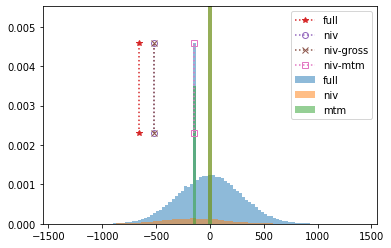

In [405]:
n_deals = 1
n_scens = 100000
pd = 0.1
perc = 1

cm_v0 = 100 * np.ones((n_deals, 1)) * (2*np.random.uniform(size=(n_deals,1)) - 0.0* 1)
cm_mv_std = 2 * cm_v0

cm_pd = pd * np.ones((n_deals, 1))
cm_thr = scipy.stats.norm.ppf(cm_pd)
mtx_cwi = np.random.standard_normal([n_deals, n_scens])
mtx_ind = mtx_cwi  < cm_thr

mtx_mv = np.random.standard_normal([n_deals, n_scens])
mtx_pnl_var = cm_mv_std * mtx_mv
mtx_pnl_mtm = - cm_v0 * mtx_ind
mtx_pnl_full = mtx_pnl_mtm + mtx_pnl_var * (1 - mtx_ind)

mtx_pnl_niv = mtx_pnl_full - mtx_pnl_var

rv_pnl_mtm = mtx_pnl_mtm.sum(axis=0)
r_var_mtm = np.percentile(rv_pnl_mtm, perc)

rv_pnl_var = mtx_pnl_var.sum(axis=0)

cv_var_niv = np.percentile(mtx_pnl_niv, perc, axis = 1)
r_var_niv_gross = np.sum(np.minimum(0, cv_var_niv))

rv_pnl_full = mtx_pnl_full.sum(axis=0)
rv_pnl_niv = mtx_pnl_niv.sum(axis=0)

r_var_full = np.percentile(rv_pnl_full, perc)
r_var_niv = np.percentile(rv_pnl_niv, perc)

xlim = np.max(np.abs(rv_pnl_full))*1.1
x_h = np.linspace(-xlim, xlim, 100)

one2 = np.ones(2)
plt.figure()
#plt.hist(mtx_loss[0], bins=x_h, density=True)
#plt.hist(mtx_loss[1], bins=x_h, density=True)
counts, bins, patches = plt.hist(rv_pnl_full, bins=x_h, density=True, label='full', alpha = 0.5)
mh = np.max(counts)
counts, bins, patches = plt.hist(rv_pnl_niv, bins=x_h, density=True, label='niv', alpha = 0.5)
#counts, bins, patches = plt.hist(rv_pnl_var, bins=x_h, density=True, label='iv', alpha = 0.5)
counts, bins, patches = plt.hist(rv_pnl_mtm, bins=x_h, density=True, label='mtm', alpha = 0.5)
plt.plot(r_var_full*one2, [mh/2, mh], '*:', label = 'full')
plt.plot(r_var_niv*one2, [mh/2, mh], 'o:', fillstyle='none', label = 'niv')
plt.plot(r_var_niv_gross*one2, [mh/2, mh], 'x:', label = 'niv-gross')
plt.plot(r_var_mtm*one2, [mh/2, mh], 's:', fillstyle='none', label = 'niv-mtm')
plt.ylim([0, mh*1.2])
plt.legend()
plt.show()